<a href="https://colab.research.google.com/github/zaneprice5/stroke_prediction/blob/main/stroke_EDA_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stroke prediction and EDA of stroke datset

This dataset is taken from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) and offers ~5000 samples with 11 clinical features predictive/not predictive of stroke. I take methods from multiple notebooks and concatenate what I think works best and offers a thorough analysis of this data.  

Source notebooks:
https://www.kaggle.com/code/casper6290/strokeprediction-99-acc ;
https://www.kaggle.com/code/bhuvanchennoju/data-storytelling-auc-focus-on-strokes ;
https://www.kaggle.com/code/thomaskonstantin/analyzing-and-modeling-stroke-data

In [113]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as ex
import plotly.graph_objs as go

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import os

from sklearn.metrics import classification_report,confusion_matrix,f1_score
import warnings
warnings.filterwarnings('ignore')

In [56]:
# read in the data and check it out
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


These are interesting features...
it's likely that some are highly correlated. Also the chance of leakage is high with the physiological observations. Hypertension, heart disease, glucose level, BMI; when are these observations recorded? After the person has presented at the ER with stroke symptoms? These features probably need to be taken with a grain of salt. 
And, how useful are these features? The ability to prevent stroke is probably much more useful for predictive modeling, right? So can we derive insights from a person's residence, urbanity, or work type? 
We alredy know someone with hypertension has a higher likelihood of suffering from a stroke...anyway, enough said, let's analyze the data. 

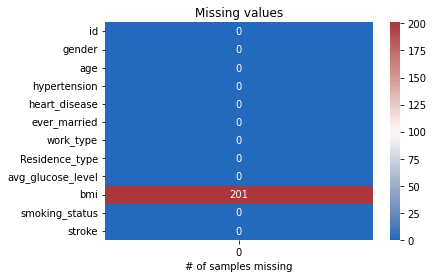

In [8]:
# let's do some basic plotting to visualize these features and data balance. 

#look for na values
plt.title('Missing values')
ax = sns.heatmap(df.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
ax.set_xlabel('# of samples missing')
plt.show()

We have multiple options for this feature. We could impute values with some type of average, we could leave na, or we can predict the values. Let's use a decision tree to predict the values based upon other physiological features; gender, age, hypertension, average glucose level. 


In [57]:
bmi_dt = Pipeline(steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
#set the predictors to X
X = df[['gender', 'age','hypertension','bmi', 'avg_glucose_level']].copy()
#make gender a class 1/0
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

#id which bmi values are missing
missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
bmi_dt.fit(X,Y)
predicted_bmi = pd.Series(bmi_dt.predict(missing[['age','gender', 'hypertension', 'avg_glucose_level']]),index=missing.index)
df.loc[missing.index,'bmi'] = predicted_bmi

In [58]:
#let's just verify that there aren't any missing bmi values now. 
df['bmi'].isna().sum()

0

We can assume that we are looking at an imbalanced dataset. It's likely there are less 'stroke' samples than not. Let's see what the proportion is. 

In [11]:
fig = ex.pie(df,names='stroke')
fig.update_layout(title='<b>Proportion Of Stroke<b>' )
fig.show()

Let's check out the distribution of the other features such as age and gender. 

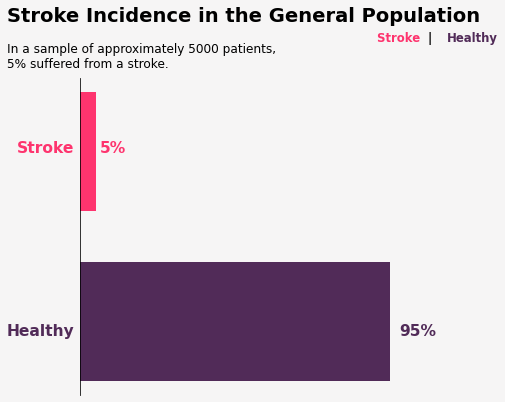

In [12]:
x = pd.DataFrame(df.groupby(['stroke'])['stroke'].count())

# plot
fig, ax = plt.subplots(figsize = (6,6), dpi = 70)
ax.barh([1], x.stroke[1], height = 0.7, color = '#fe346e')
plt.text(-1150,-0.08, 'Healthy',{'fontfamily': 'DejaVu Sans','weight':'bold','Size': '16','style':'normal', 'color':'#512b58'})
plt.text(5000,-0.08, '95%',{'fontfamily':'DejaVu Sans','weight':'bold' ,'size':'16','color':'#512b58'})
ax.barh([0], x.stroke[0], height = 0.7, color = '#512b58')
plt.text(-1000,1, 'Stroke', {'fontfamily': 'DejaVu Sans','weight':'bold','Size': '16','style':'normal', 'color':'#fe346e'})
plt.text(300,1, '5%',{'fontfamily':'DejaVu Sans', 'weight':'bold','size':'16','color':'#fe346e'})

fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

plt.text(-1150,1.77, 'Stroke Incidence in the General Population' ,{'fontfamily': 'DejaVu Sans', 'Size': '20','weight':'bold', 'color':'black'})
plt.text(4650,1.65, 'Stroke ', {'fontfamily': 'DejaVu Sans','weight':'bold','Size': '12','style':'normal', 'color':'#fe346e'})
plt.text(5450,1.65, '|', {'color':'black' , 'size':'12', 'weight': 'bold'})
plt.text(5750,1.65, 'Healthy', {'fontfamily': 'DejaVu Sans','weight':'bold', 'Size': '12','style':'normal', 'color':'#512b58'})
plt.text(-1150,1.5, 'In a sample of approximately 5000 patients,\n5% suffered from a stroke.', 
        {'fontfamily':'DejaVu Sans', 'size':'12.5','color': 'black'})

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Let's model our data with various/popular ML models and run model evaluation to see which fits the data best. 

In [ ]:
df.info()
#check for duplicates
df.duplicated().sum()

In [ ]:
#store continuous and categorical variables in lists for easy access

cont_vars = ['age', 'avg_glucose_level', 'bmi']
cat_vars = []

for i in df.columns:
  if i!= 'id' and i!= 'stroke' and i not in cont_vars:
    cat_vars.append(i)
cat_vars

In [ ]:
#take a look at values and counts for each categorical column
for i in cat_vars:
    print(f'============Values in {i}============\n{df[i].value_counts()}\n------------------------')

In [62]:
#drop the one column that has 'gender' as 'other'

df.drop(index = df[df['gender']=='Other'].index[0], axis = 0, inplace = True)

In [ ]:
#need to encode categorical variables 

#going to use dummies from pandas

# cat_vars.pop()
df_encoded = pd.get_dummies(df[cat_vars], drop_first =True)
df_encoded.head()

In [ ]:
df[df_encoded.columns] = df_encoded
df.head()

In [ ]:
df.drop(cat_vars,axis=1,inplace=True)
df.head()

In [ ]:
df_final=df.drop(['id'],axis=1)
df_final.head()

We know that the minority class (those who have suffered from strokes) is underrepresented in the sample of ~5000 samples. Therefore, we will use oversampling of the minority class to balance the data. 

In [85]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
X = df_final.drop(['stroke'], axis=1)
y = df_final['stroke']
X_oversampled, y_oversampled = oversample.fit_resample(X, y)

In [93]:
#look at rebalanced data 50/50 stroke/no stroke 
fig = ex.pie(y_oversampled,names='stroke')
fig.update_layout(title='<b>Proportion Of Stroke after Resampling<b>')
fig.show()

In [73]:
#train/test
#use stratified parameter so that test/train have equal proportion of y outcome classes

X_train, X_test, y_train, y_test = train_test_split(X_oversampled,y_oversampled,test_size=0.3,stratify=y_oversampled, random_state=42)

In [133]:
# create sklearn pipeline objects for easy scaling and fitting

dec_tree = Pipeline(steps = [('scale',StandardScaler()),('feature_selection', SelectFromModel(LinearSVC(dual = False, penalty="l1"))), ('dt',DecisionTreeClassifier(random_state=42))])
ran_forest = Pipeline(steps = [('scale',StandardScaler()), ('feature_selection', SelectFromModel(LinearSVC(dual = False, penalty="l1"))), ('rf',RandomForestClassifier(random_state=42))])
supp_vec = Pipeline(steps = [('scale',StandardScaler()), ('feature_selection', SelectFromModel(LinearSVC(dual = False, penalty="l1"))), ('svc',SVC(random_state=42))])
log_reg = Pipeline(steps = [('scale',StandardScaler()), ('feature_selection', SelectFromModel(LinearSVC(dual = False, penalty="l1"))), ('lr',LogisticRegression(random_state=42))])

In [134]:
#fit all the models

dec_tree.fit(X_train, y_train)
ran_forest.fit(X_train, y_train)
supp_vec.fit(X_train, y_train)
log_reg.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('lr', LogisticRegression(random_state=42))])

In [138]:
dec_tree[:-1].get_feature_names_out()

array(['age', 'avg_glucose_level', 'bmi', 'gender_Male',
       'ever_married_Yes', 'work_type_Private', 'work_type_Self-employed',
       'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'], dtype=object)

In [123]:
#run predictions
dt_predictions = dec_tree.predict(X_test)
rf_predictions = ran_forest.predict(X_test)
svm_predictions = supp_vec.predict(X_test)
lr_predictions = log_reg.predict(X_test)

In [124]:
#model evaluation
dt_cm  = confusion_matrix(y_test,dt_predictions)
rf_cm  = confusion_matrix(y_test,rf_predictions)
svm_cm = confusion_matrix(y_test,svm_predictions)
lr_cm  = confusion_matrix(y_test,lr_predictions)

dt_f1  = f1_score(y_test,dt_predictions)
rf_f1  = f1_score(y_test,rf_predictions)
svm_f1 = f1_score(y_test,svm_predictions)
lr_f1  = f1_score(y_test,lr_predictions)


In [142]:
#visualize our model evaluations to pick best fit
fig = go.Figure()
fig.add_trace(go.Bar(x=['Decision Tree','Random Forest','SVM','Logistic Regression'],y=[dt_f1,rf_f1,svm_f1,lr_f1]))
fig.update_layout(title='F1 Score Of Our Chosen Models',xaxis_title='Model',yaxis_title='F1 Score')
fig.show()

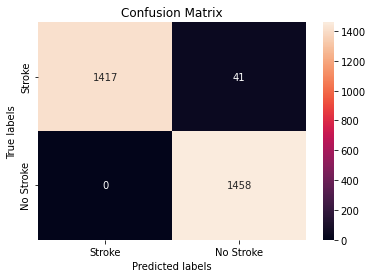

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(rf_cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Stroke', 'No Stroke']); ax.yaxis.set_ticklabels(['Stroke', 'No Stroke']);

In [140]:
#consider feature importance
fig = go.Figure()
fig.add_trace(go.Bar(x = X.columns, y=ran_forest['rf'].feature_importances_))
fig.update_layout(title='The Importance of Clinical Features on Stroke Prediction based on Mean Decrease in Impurity',xaxis_title='Feature',yaxis_title='Mean Decrease in Impurity')
fig.show()

We can also try another feature selection method called mutual information from sklearn.

In [141]:
fig = go.Figure()
fig.add_trace(go.Bar(x = X.columns, y=mutual_info_classif(X_train, y_train, discrete_features='auto', n_neighbors=5, copy=True, random_state=None)))
fig.update_layout(title='The Importance of Clinical Features on Stroke Prediction based on Mutual Information Feature Selection',xaxis_title='Feature',yaxis_title='Mutual Information Score')
fig.show()

In this case, we can see that the same three features are considered the most important, however, average glucose level is by far the most important when considered with mutual information method. However, we do feature selection inside of the sklearn pipeline automatically. But it is interesting to see this visualization. 

*More analysis to come!!*